In [1]:
import math
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pprint import pprint
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, roc_auc_score 
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data Preparation

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Check for empty cells and if data types are correct for the respective columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Exploratory Data Analysis

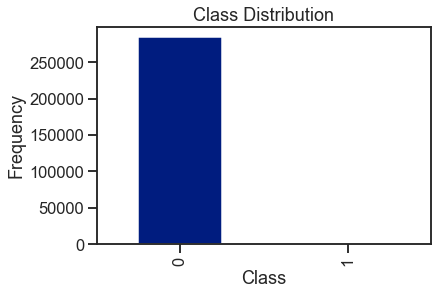

In [4]:
# Plot with seaborn
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('ticks')

classes = pd.value_counts(df['Class'], sort = True).sort_index()
classes.plot(kind = 'bar')
plt.figsize = (20,10)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency');

In [5]:
# Distribution of target variable
print(df['Class'].value_counts())

0    284315
1       492
Name: Class, dtype: int64


In [6]:
print('Non-fraudulent transactions represents', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset.')
print('Fraudulent transactions represents', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset.')

Non-fraudulent transactions represents 99.83 % of the dataset.
Fraudulent transactions represents 0.17 % of the dataset.


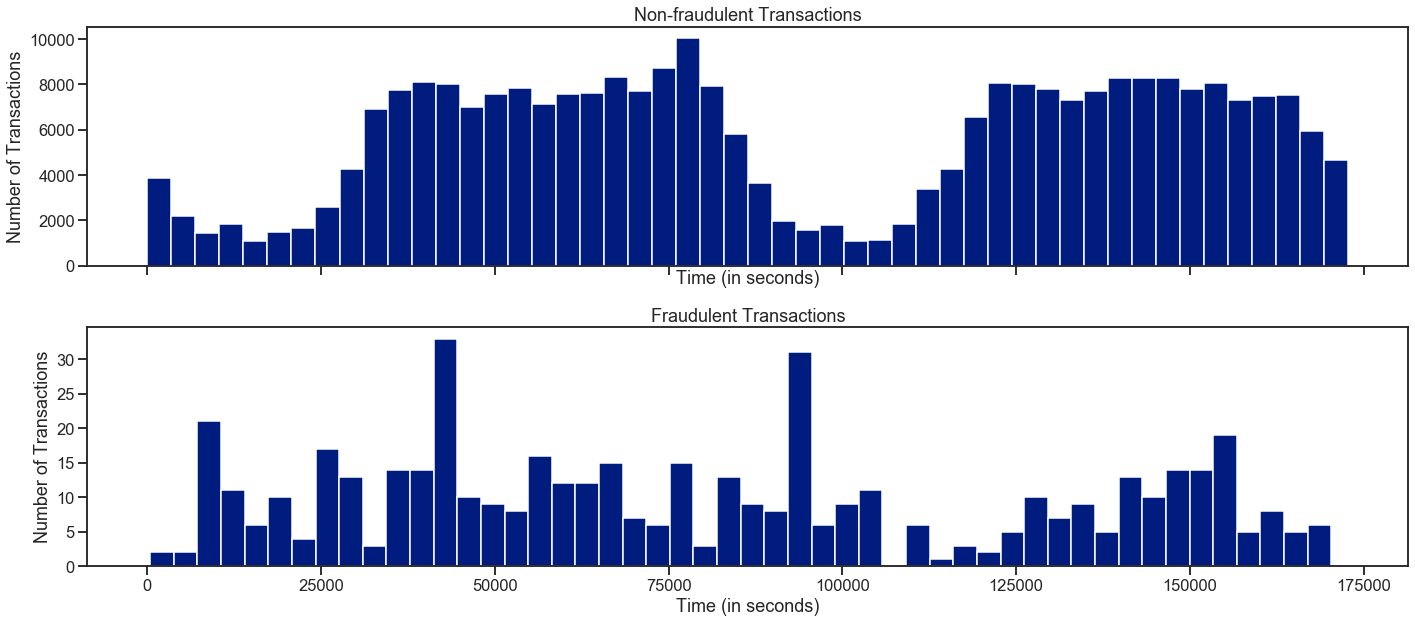

In [7]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,9))
bins = 50

ax1.hist(df.Time[df.Class==0], bins=bins)
ax1.set(xlabel='Time (in seconds)',
        ylabel='Number of Transactions',
        title='Non-fraudulent Transactions') 

ax2.hist(df.Time[df.Class==1], bins=bins)
ax2.set(xlabel='Time (in seconds)',
        ylabel='Number of Transactions',
        title='Fraudulent Transactions')

plt.tight_layout()

### Benford's Law

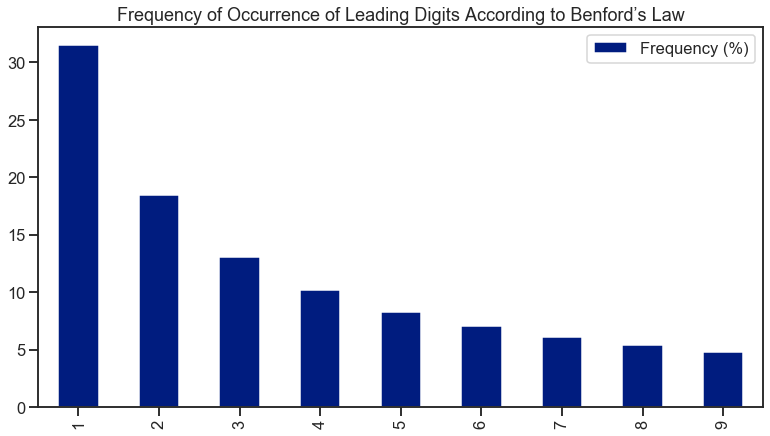

In [8]:
# Expected frequency for every digit from 1 to 9
exp=pd.Series()
for i in range(1,10):
    exp.at[i] =  math.log(1 + 1/i,9) * 100

df_BL = pd.DataFrame(columns=['Frequency (%)'])
df_BL['Frequency (%)'] = exp

df_BL.plot.bar(figsize=(13,7), title='Frequency of Occurrence of Leading Digits According to Benford’s Law');

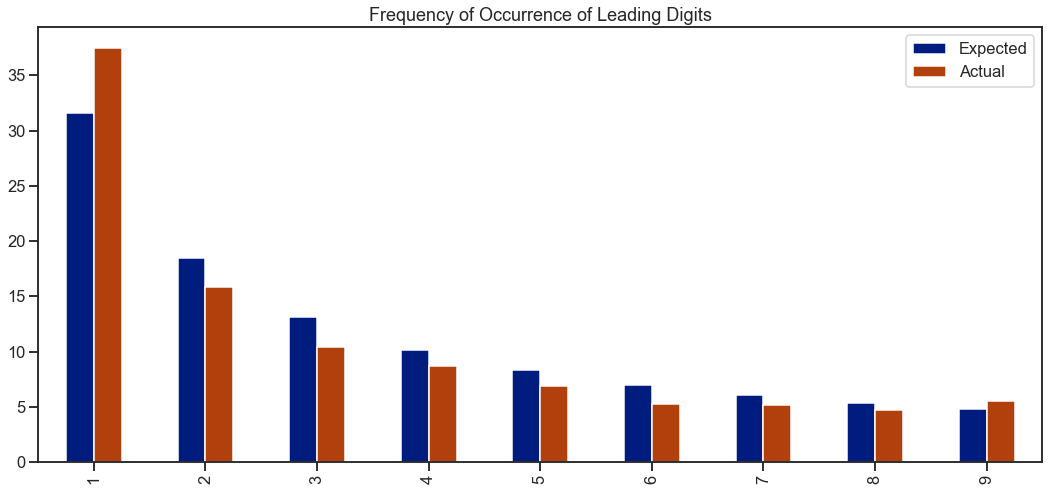

In [9]:
# Expected frequency for every digit from 1 to 9
exp = pd.Series()
for i in range(1,10):
    exp.at[i] =  math.log(1 + 1/i,9) * 100
    
# Actual frequency based on dataset   
amt = df['Amount'][df['Amount'] >= 1].apply(lambda x: x // 10**(len(str(math.floor(x))) - 1))
num_counts = amt.value_counts()
num_total = amt.count()
num_percent = num_counts.apply(lambda x: 100 * x / num_total)

df = pd.DataFrame(columns=['Expected', 'Actual'])
df['Expected'] = exp
df['Actual'] = num_percent
df.plot.bar(figsize = (18,8), title = 'Frequency of Occurrence of Leading Digits');

### Data Modelling

In [8]:
# Scale columns 'Amount' and 'Time'
std_scaler = StandardScaler()

df['amount_scaled'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['time_scaled'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   V1             284807 non-null  float64
 1   V2             284807 non-null  float64
 2   V3             284807 non-null  float64
 3   V4             284807 non-null  float64
 4   V5             284807 non-null  float64
 5   V6             284807 non-null  float64
 6   V7             284807 non-null  float64
 7   V8             284807 non-null  float64
 8   V9             284807 non-null  float64
 9   V10            284807 non-null  float64
 10  V11            284807 non-null  float64
 11  V12            284807 non-null  float64
 12  V13            284807 non-null  float64
 13  V14            284807 non-null  float64
 14  V15            284807 non-null  float64
 15  V16            284807 non-null  float64
 16  V17            284807 non-null  float64
 17  V18            284807 non-nul

In [10]:
X = df.iloc[:,np.r_[:,0:28,29,30]] # independent columns - features
y = df.iloc[:,28]                  # target column - Class

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 1)

### Model 1: Baseline Logistic Regression Model

In [12]:
# Create baseline logistic regression classifier
LR = LogisticRegression()

# Fit training data and training labels
LR.fit(X_train, y_train)

LogisticRegression()

In [13]:
print(f'Baseline Logistic Regression Model Accuracy for train data: {LR.score(X_train, y_train)}')
print(f'Baseline Logistic Regression Model Accuracy for test data: {LR.score(X_test, y_test)}')

Baseline Logistic Regression Model Accuracy for train data: 0.9992670455792315
Baseline Logistic Regression Model Accuracy for test data: 0.9991397773954567


### Synthetic Minority Oversampling Technique ("SMOTE")

In [14]:
sm = SMOTE(sampling_strategy='minority', random_state=1, k_neighbors=5)

X_train_res, y_train_res = sm.fit_sample(df.drop('Class', axis=1), df['Class'])

In [15]:
new_df = pd.concat([pd.DataFrame(X_train_res), pd.DataFrame(y_train_res)], axis=1)
new_df['Class'].value_counts()

1    284315
0    284315
Name: Class, dtype: int64

In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   V1             568630 non-null  float64
 1   V2             568630 non-null  float64
 2   V3             568630 non-null  float64
 3   V4             568630 non-null  float64
 4   V5             568630 non-null  float64
 5   V6             568630 non-null  float64
 6   V7             568630 non-null  float64
 7   V8             568630 non-null  float64
 8   V9             568630 non-null  float64
 9   V10            568630 non-null  float64
 10  V11            568630 non-null  float64
 11  V12            568630 non-null  float64
 12  V13            568630 non-null  float64
 13  V14            568630 non-null  float64
 14  V15            568630 non-null  float64
 15  V16            568630 non-null  float64
 16  V17            568630 non-null  float64
 17  V18            568630 non-nul

### Correlation Matrix with Heat Map

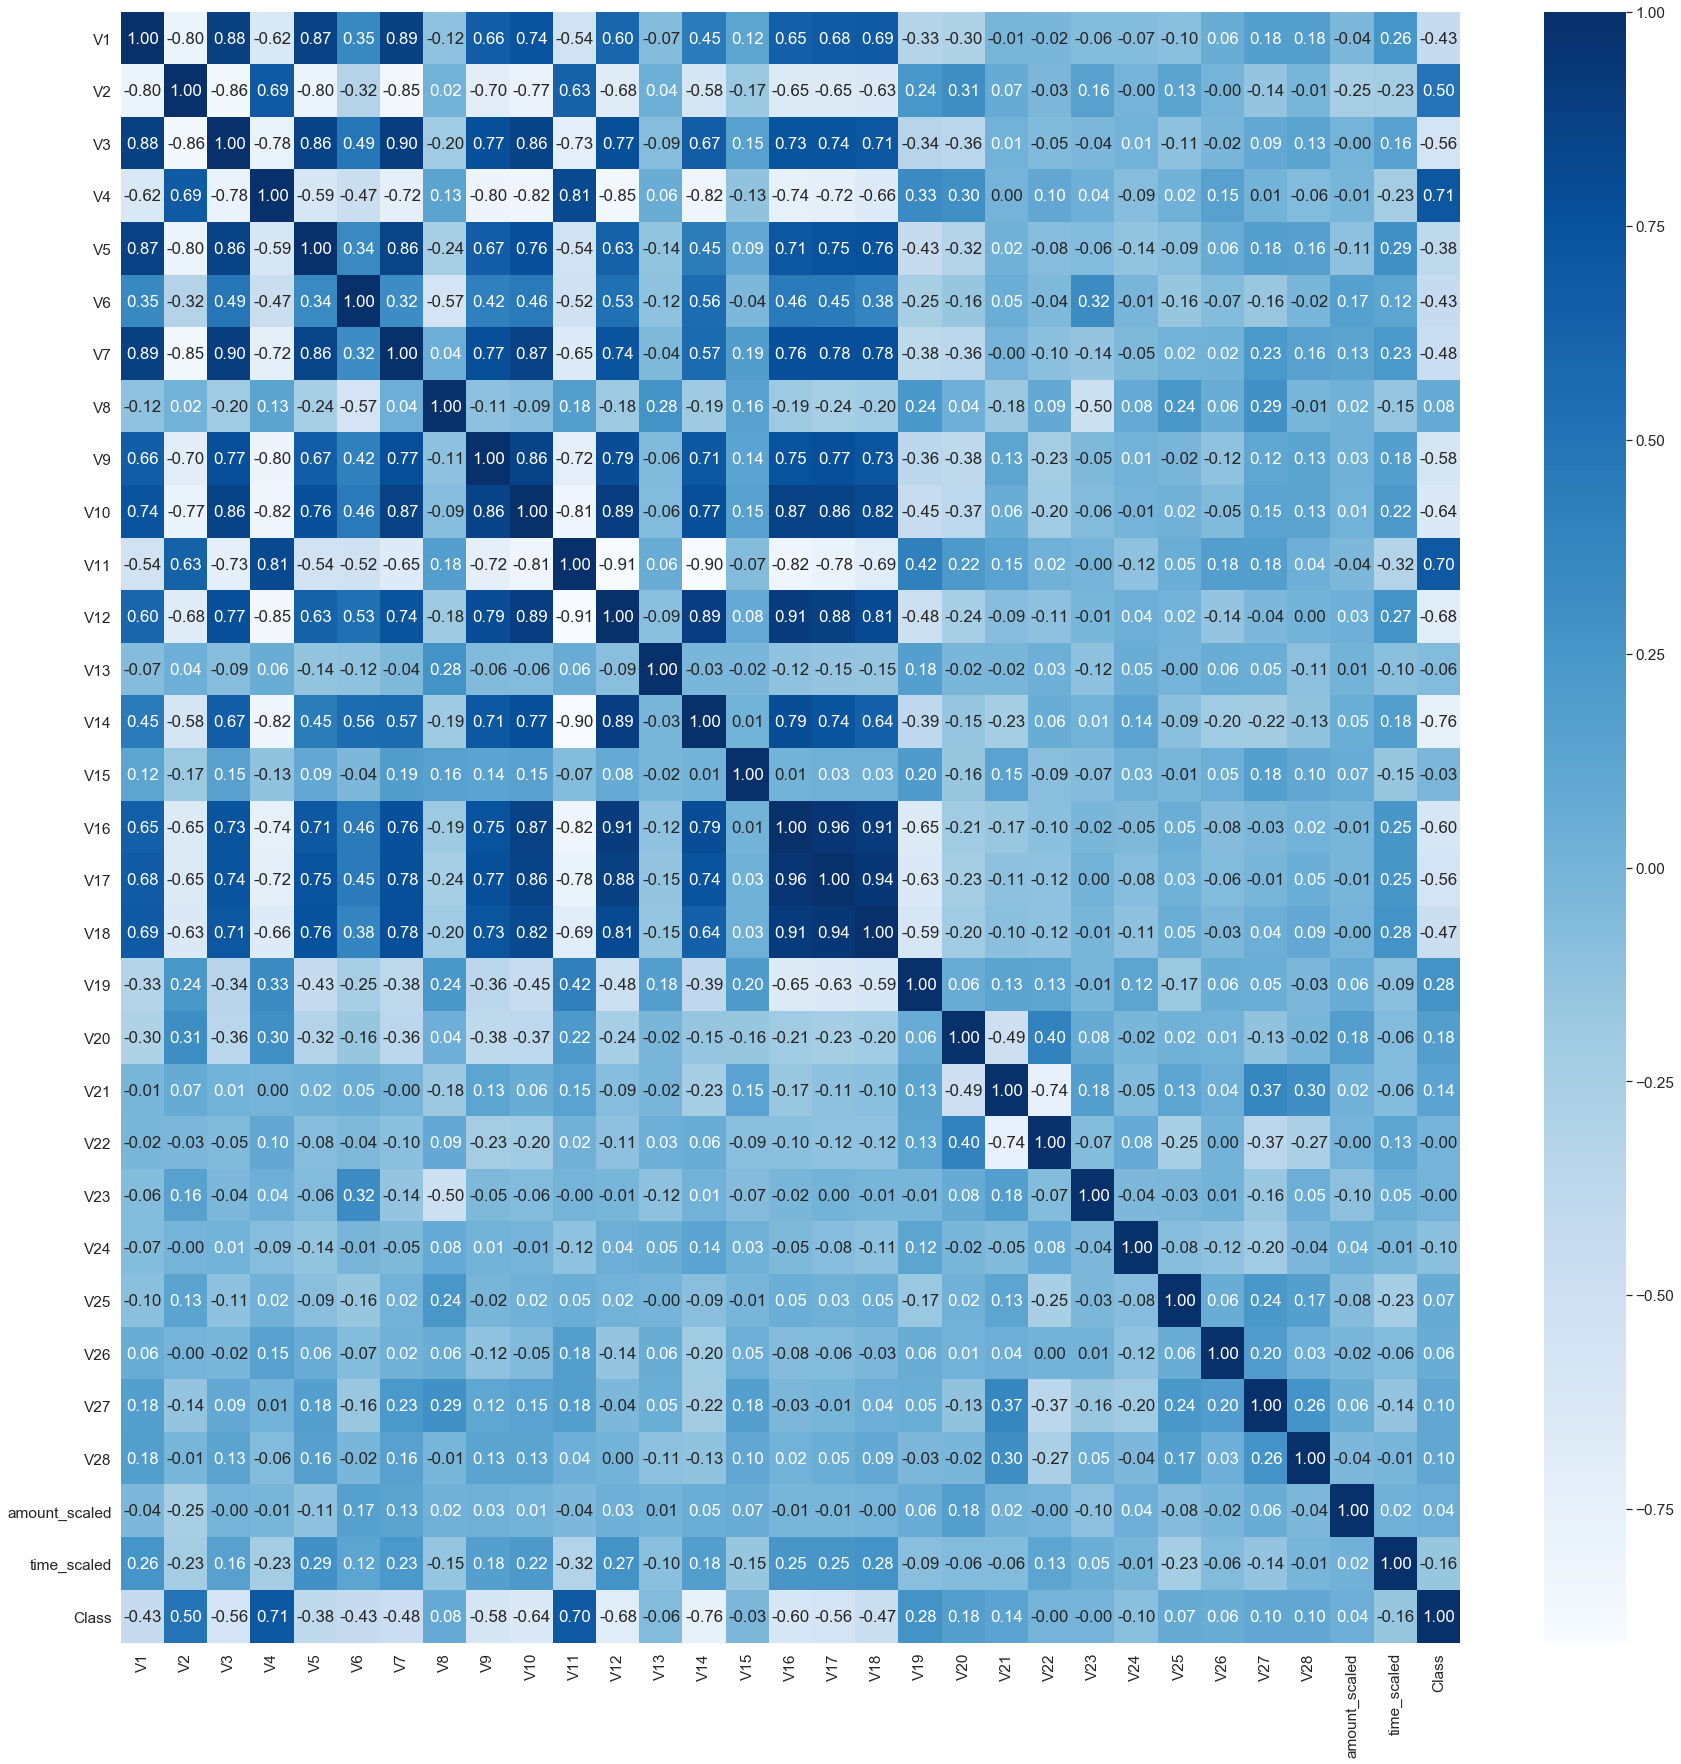

In [17]:
# Obtain correlations of each features in dataset
sns.set(font_scale=1.4)
corrmat = new_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))

# Plot heat map
correlation = sns.heatmap(new_df[top_corr_features].corr(),annot=True,fmt=".2f",cmap='Blues')

### Box Plots

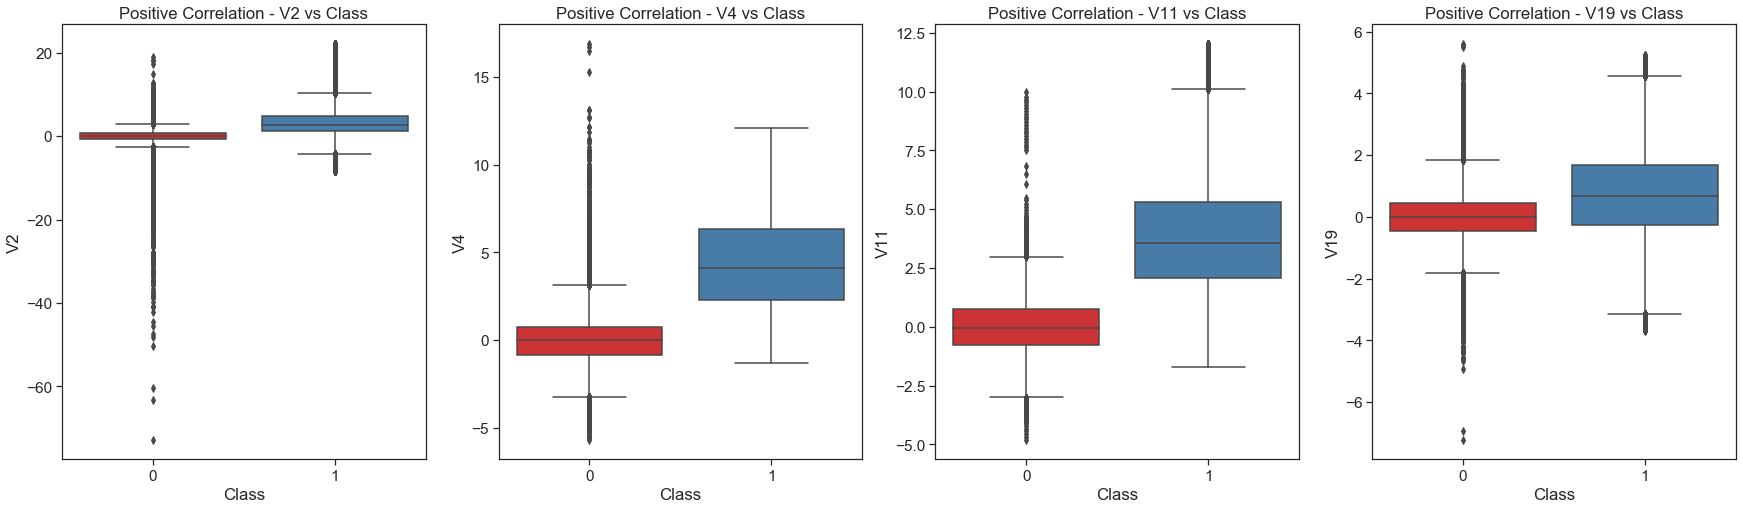

In [18]:
sns.set_style('ticks')
f, axes = plt.subplots(ncols=4, figsize=(30,8))

sns.boxplot(x='Class', y='V2', data=new_df, palette='Set1', ax=axes[0])
axes[0].set_title('Positive Correlation - V2 vs Class')

sns.boxplot(x='Class', y='V4', data=new_df, palette='Set1', ax=axes[1])
axes[1].set_title('Positive Correlation - V4 vs Class')

sns.boxplot(x='Class', y='V11', data=new_df, palette='Set1', ax=axes[2])
axes[2].set_title('Positive Correlation - V11 vs Class')

sns.boxplot(x='Class', y='V19', data=new_df, palette='Set1', ax=axes[3])
axes[3].set_title('Positive Correlation - V19 vs Class')

plt.show()

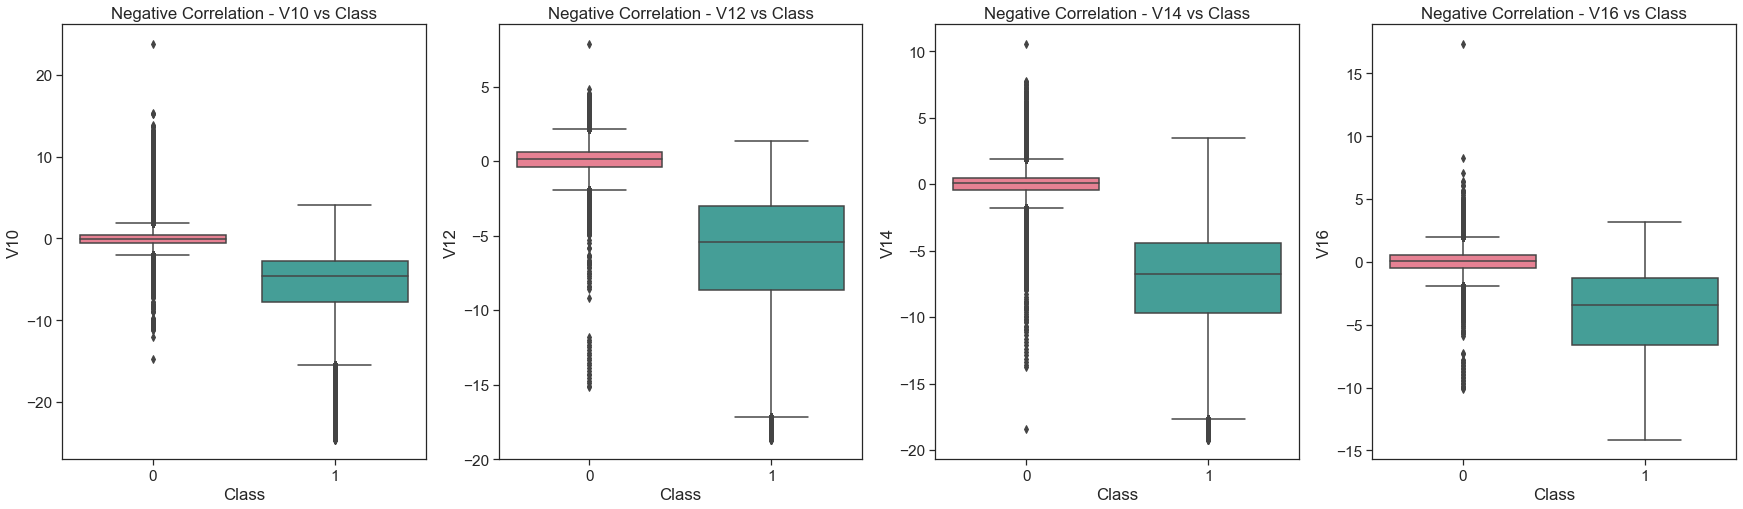

In [19]:
f, axes = plt.subplots(ncols=4, figsize=(30,8))

sns.boxplot(x='Class', y='V10', data=new_df, palette='husl', ax=axes[0])
axes[0].set_title('Negative Correlation - V10 vs Class')

sns.boxplot(x='Class', y='V12', data=new_df, palette='husl', ax=axes[1])
axes[1].set_title('Negative Correlation - V12 vs Class')

sns.boxplot(x='Class', y='V14', data=new_df, palette='husl', ax=axes[2])
axes[2].set_title('Negative Correlation - V14 vs Class')

sns.boxplot(x='Class', y='V16', data=new_df, palette='husl', ax=axes[3])
axes[3].set_title('Negative Correlation - V16 vs Class')

plt.show()

### Distribution Plot

Top 4 Features - Positive Correlation with Class



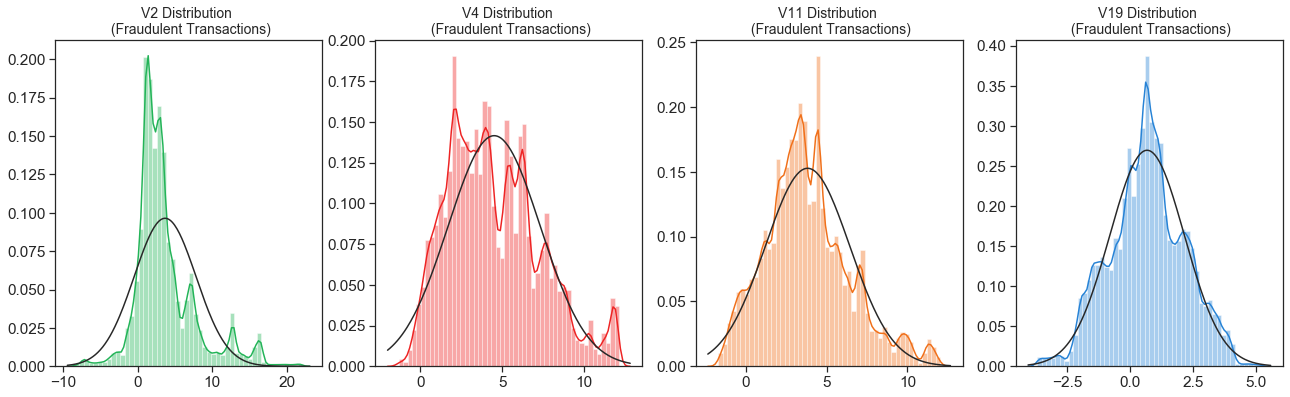

In [20]:
print('Top 4 Features - Positive Correlation with Class\n')
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(22, 6))

v2_fraud_dist = new_df['V2'].loc[new_df['Class'] == 1].values
sns.distplot(v2_fraud_dist, ax=ax1, fit=norm, color='#23b458')
ax1.set_title('V2 Distribution \n (Fraudulent Transactions)', fontsize=14)

v4_fraud_dist = new_df['V4'].loc[new_df['Class'] == 1].values
sns.distplot(v4_fraud_dist, ax=ax2, fit=norm, color='#ee2424')
ax2.set_title('V4 Distribution \n (Fraudulent Transactions)', fontsize=14)

v11_fraud_dist = new_df['V11'].loc[new_df['Class'] == 1].values
sns.distplot(v11_fraud_dist, ax=ax3, fit=norm, color='#f0701a')
ax3.set_title('V11 Distribution \n (Fraudulent Transactions)', fontsize=14)

v19_fraud_dist = new_df['V19'].loc[new_df['Class'] == 1].values
sns.distplot(v19_fraud_dist, ax=ax4, fit=norm, color='#2783d6')
ax4.set_title('V19 Distribution \n (Fraudulent Transactions)', fontsize=14)

plt.show()

Top 4 Features - Negative Correlation with Class



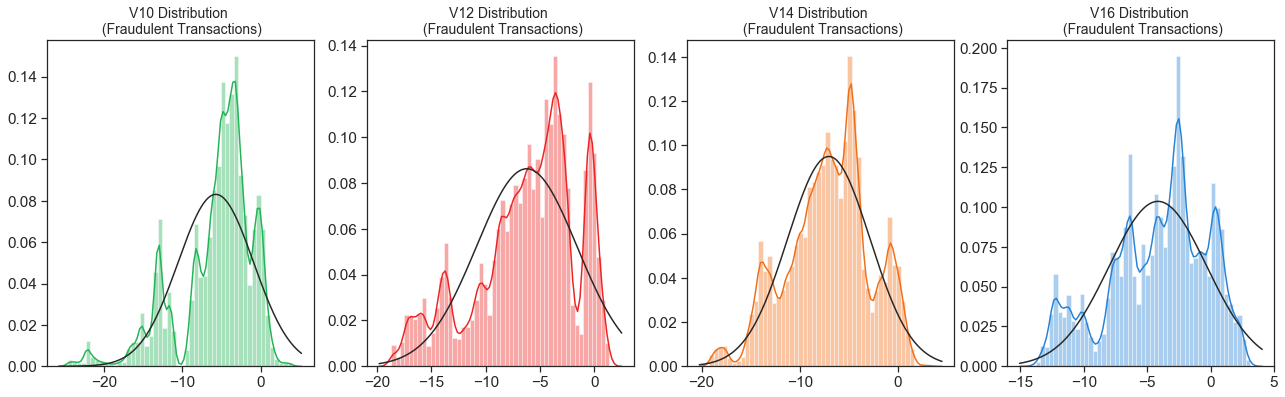

In [21]:
print('Top 4 Features - Negative Correlation with Class\n')
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(22, 6))

v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist, ax=ax1, fit=norm, color='#23b458')
ax1.set_title('V10 Distribution \n (Fraudulent Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='#ee2424')
ax2.set_title('V12 Distribution \n (Fraudulent Transactions)', fontsize=14)

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax=ax3, fit=norm, color='#f0701a')
ax3.set_title('V14 Distribution \n (Fraudulent Transactions)', fontsize=14)

v16_fraud_dist = new_df['V16'].loc[new_df['Class'] == 1].values
sns.distplot(v16_fraud_dist, ax=ax4, fit=norm, color='#2783d6')
ax4.set_title('V16 Distribution \n (Fraudulent Transactions)', fontsize=14)

plt.show()

### Removal of Extreme Outliers

In [22]:
print('Removal of Extreme Outliers from Top 4 Features which are Positively Correlated with Class\n')

# V2 - Removing extreme outliers from fraudulent transactions
print('V2 Analysis')
v2_fraud = new_df['V2'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v2_fraud, 25), np.percentile(v2_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v2_iqr = q75 - q25
print('IQR: {}'.format(v2_iqr))

v2_cut_off = v2_iqr * 1.5
v2_lower, v2_upper = q25 - v2_cut_off, q75 + v2_cut_off
print('Cut-Off: {}'.format(v2_cut_off))
print('Lower Limit: {}'.format(v2_lower))
print('Upper Limit: {}'.format(v2_upper))

outliers = [x for x in v2_fraud if x < v2_lower or x > v2_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V2'] > v2_upper) | (new_df['V2'] < v2_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V4 - Removing extreme outliers from fraudulent transactions
print('V4 Analysis')
v4_fraud = new_df['V4'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v4_iqr = q75 - q25
print('IQR: {}'.format(v4_iqr))

v4_cut_off = v4_iqr * 1.5
v4_lower, v4_upper = q25 - v4_cut_off, q75 + v4_cut_off
print('Cut-Off: {}'.format(v4_cut_off))
print('Lower Limit: {}'.format(v4_lower))
print('Upper Limit: {}'.format(v4_upper))

outliers = [x for x in v4_fraud if x < v4_lower or x > v4_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V4'] > v4_upper) | (new_df['V4'] < v4_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V11 - Removing extreme outliers from fraudulent transactions
print('V11 Analysis')
v11_fraud = new_df['V11'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v11_iqr = q75 - q25
print('IQR: {}'.format(v11_iqr))

v11_cut_off = v11_iqr * 1.5
v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
print('Cut-Off: {}'.format(v11_cut_off))
print('Lower Limit: {}'.format(v11_lower))
print('Upper Limit: {}'.format(v11_upper))

outliers = [x for x in v11_fraud if x < v11_lower or x > v11_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V11'] > v11_upper) | (new_df['V11'] < v11_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V19 - Removing extreme outliers from fraudulent transactions
print('V19 Analysis')
v19_fraud = new_df['V19'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v19_fraud, 25), np.percentile(v19_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v19_iqr = q75 - q25
print('IQR: {}'.format(v19_iqr))

v19_cut_off = v19_iqr * 1.5
v19_lower, v19_upper = q25 - v19_cut_off, q75 + v19_cut_off
print('Cut-Off: {}'.format(v19_cut_off))
print('Lower Limit: {}'.format(v19_lower))
print('Upper Limit: {}'.format(v19_upper))

outliers = [x for x in v19_fraud if x < v19_lower or x > v19_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V19'] > v19_upper) | (new_df['V19'] < v19_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))

Removal of Extreme Outliers from Top 4 Features which are Positively Correlated with Class

V2 Analysis
25th Quartile: 1.2436148338080606 | 75th Quartile: 4.8940447071801945
IQR: 3.6504298733721336
Cut-Off: 5.475644810058201
Lower Limit: -4.23202997625014
Upper Limit: 10.369689517238395
Number of Outliers: 27534
Number of Instances after Removing Outliers: 537173


V4 Analysis
25th Quartile: 2.125846360775513 | 75th Quartile: 5.9632091856761615
IQR: 3.8373628249006484
Cut-Off: 5.756044237350973
Lower Limit: -3.6301978765754597
Upper Limit: 11.719253423027133
Number of Outliers: 4739
Number of Instances after Removing Outliers: 531449


V11 Analysis
25th Quartile: 1.9476857223201671 | 75th Quartile: 5.073128154262656
IQR: 3.1254424319424885
Cut-Off: 4.688163647913733
Lower Limit: -2.7404779255935656
Upper Limit: 9.761291802176387
Number of Outliers: 6387
Number of Instances after Removing Outliers: 524791


V19 Analysis
25th Quartile: -0.35805425944984215 | 75th Quartile: 1.827679916873

In [23]:
print('Removal of Extreme Outliers from Top 4 Features which are Negatively Correlated with Class\n')

# V10 - Removing extreme outliers from fraudulent transactions
print('V10 Analysis')
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v10_iqr = q75 - q25
print('IQR: {}'.format(v10_iqr))

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('Cut-Off: {}'.format(v10_cut_off))
print('Lower Limit: {}'.format(v10_lower))
print('Upper Limit: {}'.format(v10_upper))

outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V12 - Removing extreme outliers from fraudulent transactions
print('V12 Analysis')
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v12_iqr = q75 - q25
print('IQR: {}'.format(v12_iqr))

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('Cut-Off: {}'.format(v12_cut_off))
print('Lower Limit: {}'.format(v12_lower))
print('Upper Limit: {}'.format(v12_upper))

outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V14 - Removing extreme outliers from fraudulent transactions
print('V14 Analysis')
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('IQR: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut-Off: {}'.format(v14_cut_off))
print('Lower Limit: {}'.format(v14_lower))
print('Upper Limit: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V16 - Removing extreme outliers from fraudulent transactions
print('V16 Analysis')
v16_fraud = new_df['V16'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v16_fraud, 25), np.percentile(v16_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v16_iqr = q75 - q25
print('IQR: {}'.format(v16_iqr))

v16_cut_off = v16_iqr * 1.5
v16_lower, v16_upper = q25 - v16_cut_off, q75 + v16_cut_off
print('Cut-Off: {}'.format(v16_cut_off))
print('Lower Limit: {}'.format(v16_lower))
print('Upper Limit: {}'.format(v16_upper))

outliers = [x for x in v16_fraud if x < v16_lower or x > v16_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V16'] > v16_upper) | (new_df['V16'] < v16_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))

Removal of Extreme Outliers from Top 4 Features which are Negatively Correlated with Class

V10 Analysis
25th Quartile: -6.216467472088323 | 75th Quartile: -2.361701532929717
IQR: 3.854765939158606
Cut-Off: 5.782148908737909
Lower Limit: -11.998616380826231
Upper Limit: 3.4204473758081924
Number of Outliers: 23883
Number of Instances after Removing Outliers: 498158


V12 Analysis
25th Quartile: -6.942823173282367 | 75th Quartile: -2.5313300048755742
IQR: 4.411493168406793
Cut-Off: 6.617239752610189
Lower Limit: -13.560062925892556
Upper Limit: 4.085909747734615
Number of Outliers: 5289
Number of Instances after Removing Outliers: 492851


V14 Analysis
25th Quartile: -8.378138527549353 | 75th Quartile: -3.9232551243586427
IQR: 4.454883403190711
Cut-Off: 6.682325104786067
Lower Limit: -15.06046363233542
Upper Limit: 2.759069980427424
Number of Outliers: 74
Number of Instances after Removing Outliers: 492090


V16 Analysis
25th Quartile: -4.36155425444434 | 75th Quartile: -0.5069819560007

In [24]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491291 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   V1             491291 non-null  float64
 1   V2             491291 non-null  float64
 2   V3             491291 non-null  float64
 3   V4             491291 non-null  float64
 4   V5             491291 non-null  float64
 5   V6             491291 non-null  float64
 6   V7             491291 non-null  float64
 7   V8             491291 non-null  float64
 8   V9             491291 non-null  float64
 9   V10            491291 non-null  float64
 10  V11            491291 non-null  float64
 11  V12            491291 non-null  float64
 12  V13            491291 non-null  float64
 13  V14            491291 non-null  float64
 14  V15            491291 non-null  float64
 15  V16            491291 non-null  float64
 16  V17            491291 non-null  float64
 17  V18            491291 non-nul

In [25]:
X_clean = new_df.iloc[:,0:30] # independent columns - features
y_clean = new_df.iloc[:,30]   # target column - Class

In [26]:
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean,
                                                                            test_size = 0.2,
                                                                            random_state = 1)

### Model 2: Optimized Logistic Regression Model

In [27]:
# Set the model parameters for grid search
log_reg_params = {'penalty': ['l1', 'l2'], 
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Set up grid search meta-estimator
grid_search = GridSearchCV(LogisticRegression(), log_reg_params, 
                           n_jobs=-1, scoring='roc_auc', cv=3)

# Train the grid search meta-estimator to obtain optimal model
opt_LR = grid_search.fit(X_train_clean, y_train_clean)

# Print optimal hyperparameters
pprint(opt_LR.best_estimator_.get_params())

{'C': 1000,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [28]:
print(f'Optimized Logistic Regression Model Accuracy for train data: {opt_LR.score(X_train_clean, y_train_clean)}')
print(f'Optimized Logistic Regression Model Accuracy for test data: {opt_LR.score(X_test_clean, y_test_clean)}')

Optimized Logistic Regression Model Accuracy for train data: 0.9875060765975525
Optimized Logistic Regression Model Accuracy for test data: 0.9869320837459673


### Model 3: Naive Bayes Model

In [29]:
# Create Naive Bayes classifier
NB = BernoulliNB()

# Fit training data and training labels
NB.fit(X_train_clean, y_train_clean)

BernoulliNB()

In [30]:
print(f'Naive Bayes Model Accuracy for train data: {NB.score(X_train_clean, y_train_clean)}')
print(f'Naive Bayes Model Accuracy for test data: {NB.score(X_test_clean, y_test_clean)}')

Naive Bayes Model Accuracy for train data: 0.9026466038388732
Naive Bayes Model Accuracy for test data: 0.9037340090984032


### Performance Evaluation of Models

In [31]:
# Predict target variables (ie. labels) for each classifer
lr_classifier_name = ['Baseline Logistic Regression']
lr_predicted_labels = LR.predict(X_test)

opt_lr_classifier_name = ['Optimized Logistic Regression']
opt_lr_predicted_labels = opt_LR.predict(X_test_clean)

nb_classifier_name = ['Naive Bayes']
nb_predicted_labels = NB.predict(X_test_clean)

### 1. Classification Report

In [32]:
print("Classification Report for", lr_classifier_name, " :\n ",
      metrics.classification_report(y_test, lr_predicted_labels, 
                                    target_names=['Non-Fraudulent','Fraud']))

print("Classification Report for ", opt_lr_classifier_name, " :\n ",
      metrics.classification_report(y_test_clean, opt_lr_predicted_labels,
                                   target_names=['Non-Fraudulent','Fraud']))

print("Classification Report for ", nb_classifier_name, " :\n ",
      metrics.classification_report(y_test_clean, nb_predicted_labels,
                                   target_names=['Non-Fraudulent','Fraud']))

Classification Report for ['Baseline Logistic Regression']  :
                  precision    recall  f1-score   support

Non-Fraudulent       1.00      1.00      1.00     56875
         Fraud       0.83      0.55      0.66        87

      accuracy                           1.00     56962
     macro avg       0.91      0.78      0.83     56962
  weighted avg       1.00      1.00      1.00     56962

Classification Report for  ['Optimized Logistic Regression']  :
                  precision    recall  f1-score   support

Non-Fraudulent       0.93      0.98      0.95     55338
         Fraud       0.97      0.90      0.93     42921

      accuracy                           0.94     98259
     macro avg       0.95      0.94      0.94     98259
  weighted avg       0.94      0.94      0.94     98259

Classification Report for  ['Naive Bayes']  :
                  precision    recall  f1-score   support

Non-Fraudulent       0.86      0.99      0.92     55338
         Fraud       0.98      

### 2. Confusion Matrix

Confusion Matrix for ['Baseline Logistic Regression']


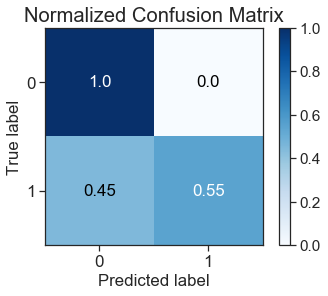

Confusion Matrix for ['Optimized Logistic Regression']


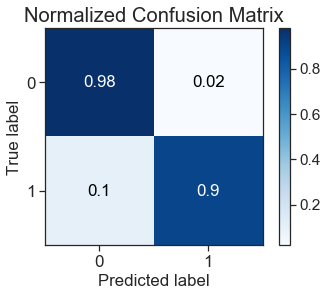

Confusion Matrix for ['Naive Bayes']


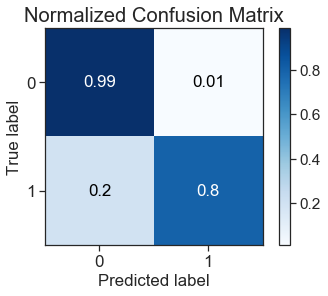

In [33]:
print("Confusion Matrix for", lr_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test, lr_predicted_labels, normalize=True)
plt.show()

print("Confusion Matrix for", opt_lr_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test_clean, opt_lr_predicted_labels, normalize=True)
plt.show()

print("Confusion Matrix for", nb_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test_clean, nb_predicted_labels, normalize=True)
plt.show()

### 3. Precision-Recall Curve

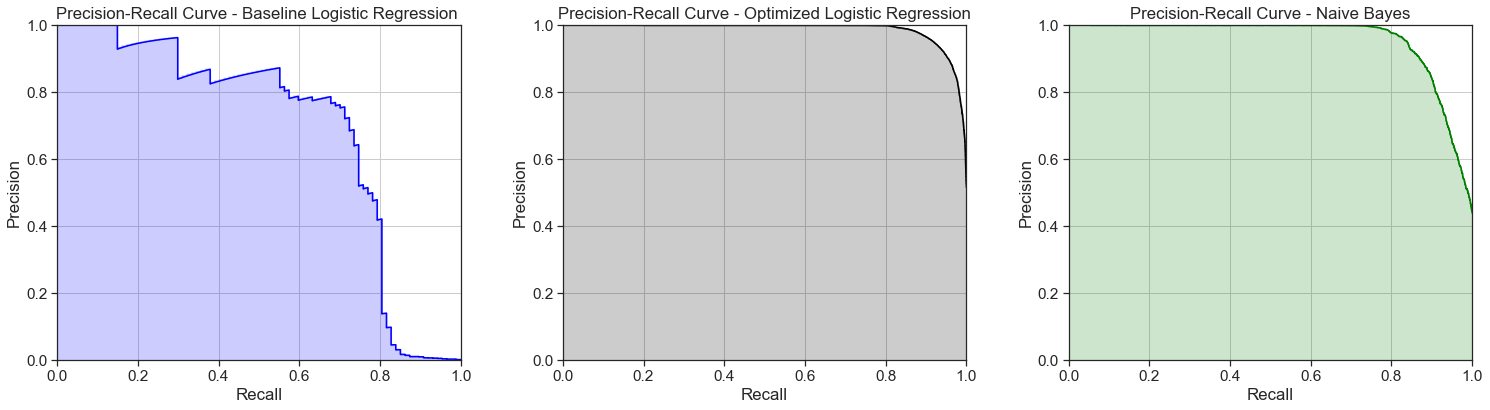

In [34]:
fig, axList = plt.subplots(ncols=3)
fig.set_size_inches(21,6)

# Plot the Precision-Recall curve for Baseline Logistic Regression  
ax = axList[0]
lr_predicted_proba = LR.predict_proba(X_test)
precision, recall, _ = precision_recall_curve(y_test, lr_predicted_proba[:,1])
ax.plot(recall, precision,color='blue')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Baseline Logistic Regression ')
ax.step(recall, precision, color='blue', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='blue')
ax.grid(True)

# Plot the Precision-Recall curve for Optimized Logistic Regression
ax = axList[1]
opt_lr_predicted_proba = opt_LR.predict_proba(X_test_clean)
precision, recall, _ = precision_recall_curve(y_test_clean, opt_lr_predicted_proba[:,1])
ax.plot(recall, precision,color='black')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Optimized Logistic Regression')
ax.step(recall, precision, color='black', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='black')
ax.grid(True)

# Plot the Precision-Recall curve for Naive Bayes
ax = axList[2]
nb_predicted_proba = NB.predict_proba(X_test_clean)
precision, recall, _ = precision_recall_curve(y_test_clean, nb_predicted_proba[:,1])
ax.plot(recall, precision,color='green')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Naive Bayes')
ax.step(recall, precision, color='green', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='green')
ax.grid(True)
plt.tight_layout()

### 4. ROC Curve and AUC

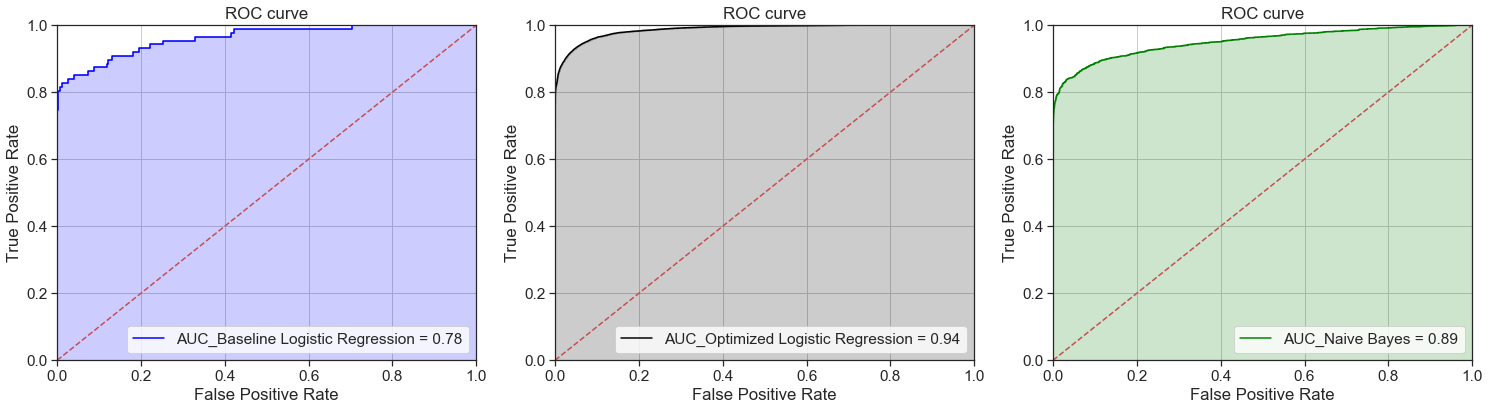

In [35]:
fig, axList = plt.subplots(ncols=3)
fig.set_size_inches(21,6)

# Plot the ROC-AUC curve for Baseline Logistic Regression
ax = axList[0]
lr = LR.fit(X_train, y_train.values.ravel()) 
lr_predicted_label_r = LR.predict_proba(X_test)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test, lr_predicted_labels)
    ax.plot(fpr, tpr, color = 'blue', label = 'AUC_Baseline Logistic Regression = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.step(fpr, tpr, color='blue', alpha=0.2, where='post')
    ax.fill_between(fpr, tpr, step='post', alpha=0.2, color='blue')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC curve')       
    
plot_auc(y_test, lr_predicted_label_r)
ax.grid(True)

# Plot the ROC-AUC curve for Optimized Logistic Regression
ax = axList[1]
opt_lr = opt_LR.fit(X_train_clean, y_train_clean.values.ravel()) 
opt_lr_predicted_label_r = opt_LR.predict_proba(X_test_clean)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test_clean, opt_lr_predicted_labels)
    ax.plot(fpr, tpr, color = 'black', label = 'AUC_Optimized Logistic Regression = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.step(fpr, tpr, color='black', alpha=0.2, where='post')
    ax.fill_between(fpr, tpr, step='post', alpha=0.2, color='black')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC curve') 
    
plot_auc(y_test_clean, opt_lr_predicted_label_r);
ax.grid(True)

# Plot the ROC-AUC curve for Naive Bayes
ax = axList[2]
nb = NB.fit(X_train_clean, y_train_clean.values.ravel()) 
nb_predicted_label_r = NB.predict_proba(X_test_clean)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test_clean, nb_predicted_labels)
    ax.plot(fpr, tpr, color = 'green', label = 'AUC_Naive Bayes = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.step(fpr, tpr, color='green', alpha=0.2, where='post')
    ax.fill_between(fpr, tpr, step='post', alpha=0.2, color='green')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC curve') 
    
plot_auc(y_test_clean, nb_predicted_label_r);
ax.grid(True)
plt.tight_layout()

### 5. Calibration Curve

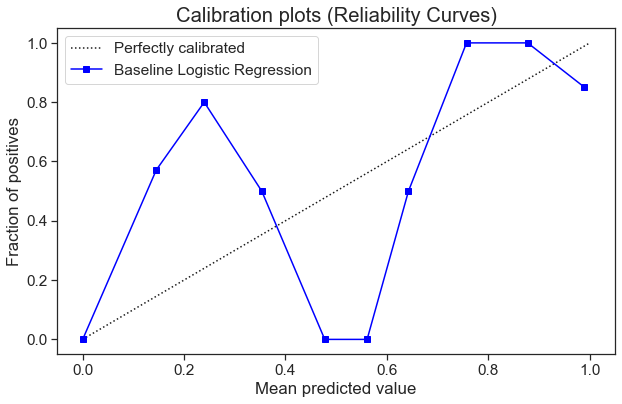

In [36]:
# Plot calibration curves for a set of classifier probability estimates
lr_probas = LR.fit(X_train, y_train).predict_proba(X_test)

probas_list = [lr_probas]
clf_names = ['Baseline Logistic Regression']

skplt.metrics.plot_calibration_curve(y_test, probas_list, clf_names, cmap='winter', figsize=(10,6))
plt.legend(loc = 'best')
plt.show()

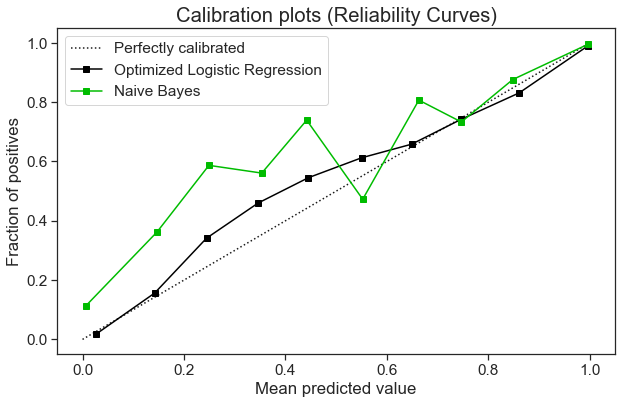

In [37]:
# Plot calibration curves for a set of classifier probability estimates
opt_lr_probas = opt_LR.fit(X_train_clean, y_train_clean).predict_proba(X_test_clean)
nb_probas = NB.fit(X_train_clean, y_train_clean).predict_proba(X_test_clean)

probas_list = [opt_lr_probas, nb_probas]
clf_names = ['Optimized Logistic Regression','Naive Bayes']

skplt.metrics.plot_calibration_curve(y_test_clean, probas_list, clf_names, figsize=(10,6))
plt.legend(loc = 'best')
plt.show()